In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse

In [2]:
import utilitis_FEEC.bsplines       as bsp
import utilitis_FEEC.projectors_mhd as mhd
import utilitis_FEEC.projectors     as proj
import utilitis_FEEC.derivatives    as der
import utilitis_FEEC.evaluation     as eva

import utilitis_FEEC.mass_matrices  as mass
import utilitis_FEEC.mappings       as maps

In [3]:
import utilitis_PIC.ECHO_fields
import utilitis_PIC.ECHO_pusher
import utilitis_PIC.ECHO_accumulation

In [4]:
#====================================================================================
#  calling epyccel for particle pusher
#====================================================================================
from pyccel.epyccel import epyccel

pic_fields = epyccel(utilitis_PIC.ECHO_fields)
pic_pusher = epyccel(utilitis_PIC.ECHO_pusher)
pic_accumu = epyccel(utilitis_PIC.ECHO_accumulation)

print('pyccelization done!')
#====================================================================================

pyccelization done!


In [331]:
Nel = [4, 4, 40]           # mesh generation on logical domain
bc  = [True, True, True]   # boundary conditions
p   = [2, 2, 2]            # splines degrees  
L   = [1., 1., 2*np.pi]    # box lengthes of physical domain


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors
t         = [T[1:-1] for T in T]                                               # reduced knot vectors
Nbase0    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions in V0
Nbase_old = [Nel + p for Nel, p, bc in zip(Nel, p, bc)]                        # TODO delete this later
Ntot      = Nbase0[0] *Nbase0[1]*Nbase0[2]                                     # total number of basis functions
delta     = [1/Nel for Nel in Nel]                                             # element sizes


# geometry
DF      = np.array([[  L[0], 0., 0.], [0.,   L[1], 0.], [0., 0.,   L[2]]])
DFinv   = np.array([[1/L[0], 0., 0.], [0., 1/L[1], 0.], [0., 0., 1/L[2]]])

G       = np.array([[  L[0]**2, 0., 0.], [0.,   L[1]**2, 0.], [0., 0.,   L[2]**2]])
Ginv    = np.array([[1/L[0]**2, 0., 0.], [0., 1/L[1]**2, 0.], [0., 0., 1/L[2]**2]])

g_sqrt  = L[0]*L[1]*L[2]

mapping = maps.mappings(['slab', L[0], L[1], L[2]]) 

# time step
dt = 0.05


# coefficients for pp-forms in interval [0, delta] (N and D)
pp0 = []
pp1 = []

for i in range(3):
    if p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    else:
        print('So far only cubic and quadratic splines implemented!')
        

# background quantities
Ueq_phys = np.array([0., 0., 0.])     # background bulk flow (vector/1-form on physical domain)
Ueq      = DF.T.dot(Ueq_phys)         # background bulk flow (1-form on logical domain)


Beq_phys = np.array([0., 0., 1.])     # background magnetic field (vector/2-form on physical domain)
Beq      = g_sqrt*DFinv.dot(Beq_phys) # background magnetic field (2-form on logical domain)

B0_23    = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (0.)
B0_31    = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0.)   
B0_12    = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (1.)   

B0_hat   = [B0_23, B0_31, B0_12]

rho0_123 = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * (1.) # background bulk mass density on logical domain


# initial conditions
k   = 1.    # wavenumber of initial perturbation
amp = 1e-5  # amplitude  of initial perturbation

B1_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (amp * np.sin(k * q3 *L[2]))
B2_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0. * q1)
B3_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (0. * q1)

U1_ini = lambda q1, q2, q3 : mapping.DF[0][0](q1, q2, q3) * (0. * q1)  # actually DF.T !!
U2_ini = lambda q1, q2, q3 : mapping.DF[1][1](q1, q2, q3) * (0. * q1)  # actually DF.T !!
U3_ini = lambda q1, q2, q3 : mapping.DF[2][2](q1, q2, q3) * (0. * q1)  # actually DF.T !!

In [332]:
# reserve memory for unknowns
b1,     b2,     b3     = np.empty(Ntot), np.empty(Ntot), np.empty(Ntot)
u1,     u2,     u3     = np.empty(Ntot), np.empty(Ntot), np.empty(Ntot)
u1_old, u2_old, u3_old = np.empty(Ntot), np.empty(Ntot), np.empty(Ntot)

b     = np.empty(3*Ntot, dtype=float)
u     = np.empty(3*Ntot, dtype=float)
u_old = np.empty(3*Ntot, dtype=float)

mat11 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat12 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat13 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

mat22 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat23 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat33 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

vec1  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec2  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec3  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

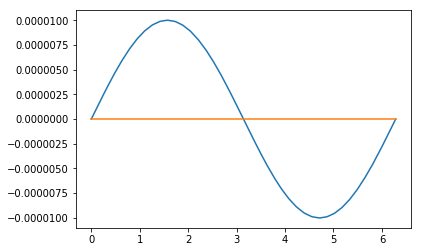

In [333]:
# create object for projecting initial conditions
PRO = proj.projectors_3d(p, Nbase_old, T, bc)

# left-hand sides of projectors
PRO.assemble_V1()
PRO.assemble_V2()

# projection of initial conditions
b1[:], b2[:], b3[:] = PRO.PI_2([B1_ini, B2_ini, B3_ini])
u1[:], u2[:], u3[:] = PRO.PI_1([U1_ini, U2_ini, U3_ini])

# plot initial condition on physical domain
q1plot = np.array([0.5])
q2plot = np.array([0.5])
q3plot = np.linspace(0., 1., 200)

Bini1, Bini2, Bini3 = eva.FEM_field_V2_3d([b1, b2, b3], [q1plot, q2plot, q3plot], T, p, bc)
Uini1, Uini2, Uini3 = eva.FEM_field_V1_3d([u1, u2, u3], [q1plot, q2plot, q3plot], T, p, bc)

plt.plot(q3plot*L[2], 1/g_sqrt*DF[0, 0]*Bini1)
plt.plot(q3plot*L[2], DFinv[0, 0]*Uini1)

In [334]:
# create object for projecting MHD matrices
MHD = mhd.projections_mhd(p, Nbase_old, T, bc)

# right-hand side of projection matrices
W1,   W2,   W3   = MHD.projection_W(rho0_123, mapping.g_sqrt)
TAU1, TAU2, TAU3 = MHD.projection_T(B0_hat, mapping.Ginv)

# mass matrices in V1 and V2
M1 = mass.mass_V1(T, p, bc, mapping.Ginv, mapping.g_sqrt)
M2 = mass.mass_V2(T, p, bc, mapping.G, mapping.g_sqrt)

# discrete curl and div matrices
derivatives = der.discrete_derivatives(p, T, bc)

CURL = derivatives.CURL_3d(T, p, bc)
DIV  = derivatives.DIV_3d(T, p, bc)

# perform projections of TAU1, TAU2, TAU3
TAU1 = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, TAU1)
TAU2 = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, TAU2)
TAU3 = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, TAU3)

TAU  = sparse.bmat([[TAU1], [TAU2], [TAU3]], format='csc')

# perform projections of W1, W2, W3
W1   = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, W1)
W2   = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, W2)
W3   = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, W3)

W    = sparse.bmat([[W1, None, None], [None, W2, None], [None, None, W3]], format='csc')

# compute matrix A
A = 1/2*(M1.dot(W) + W.T.dot(M1))

# LU decompostion of Schur complement in step 2
STEP2_schur_LU = sparse.linalg.splu((A + dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc())

# other matrices needed in step2
STEP2_1 = (A - dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc()
STEP2_2 = dt*TAU.T.dot(CURL.T.dot(M2)).tocsc()

A = A.toarray()

In [335]:
import sobol_seq
import scipy.special as sp
 

Np  = int(1e5)         # total number of particles
vth = 1.               # thermal velocity of particles in all directions
v0  = 2.               # mean velocity of particles in z-direction
nuh = 0.05             # ratio of hot/cold mass densities        
nh0 = (1.)*nuh*g_sqrt  # hot ion number density on logical domain

# create particles with random numbers
particles        = np.empty((Np, 7), dtype=float, order='F')

particles[:, :6] = sobol_seq.i4_sobol_generate(6, Np)
#particles[:, :6] = np.random.rand(Np, 6)

# transform velocities to Maxwellians
particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*vth
particles[:, 4]  = sp.erfinv(2*particles[:, 4] - 1)*vth
particles[:, 5]  = sp.erfinv(2*particles[:, 5] - 1)*vth + v0

# compute weights
particles[:, 6]  = nh0/Np 


# compute spans
spans0       = np.empty((Np, 3), dtype=int, order='F')
spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]

# empty matrices for fields at particle positions
B_part = np.empty((Np, 3), dtype=float, order='F')
U_part = np.empty((Np, 3), dtype=float, order='F')

(array([3.0000e+00, 9.0000e+00, 2.6000e+01, 6.8000e+01, 1.6500e+02,
        3.7300e+02, 7.6600e+02, 1.4480e+03, 2.5190e+03, 4.0190e+03,
        5.8930e+03, 7.9360e+03, 9.8120e+03, 1.1148e+04, 1.1631e+04,
        1.1147e+04, 9.8140e+03, 7.9340e+03, 5.8910e+03, 4.0220e+03,
        2.5170e+03, 1.4500e+03, 7.6600e+02, 3.7100e+02, 1.6600e+02,
        6.7000e+01, 2.7000e+01, 8.0000e+00, 3.0000e+00]),
 array([-1.        , -0.79310345, -0.5862069 , -0.37931034, -0.17241379,
         0.03448276,  0.24137931,  0.44827586,  0.65517241,  0.86206897,
         1.06896552,  1.27586207,  1.48275862,  1.68965517,  1.89655172,
         2.10344828,  2.31034483,  2.51724138,  2.72413793,  2.93103448,
         3.13793103,  3.34482759,  3.55172414,  3.75862069,  3.96551724,
         4.17241379,  4.37931034,  4.5862069 ,  4.79310345,  5.        ]),
 <a list of 29 Patch objects>)

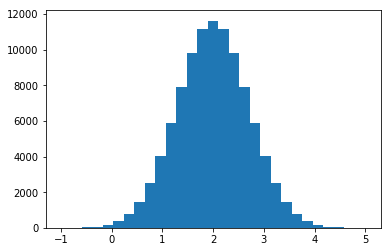

In [336]:
plt.hist(particles[:, 5], bins = np.linspace(-1., 5., 30))

In [337]:
b[:] = np.concatenate((b1, b2, b3))
u[:] = np.concatenate((u1, u2, u3))


# compute initial fields at particle positions
pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(u[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)


# initial energies
en_U = 1/2*u.dot(A.dot(u))
en_B = 1/2*b.dot(M2.dot(b))
en_H = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)

energies = np.array([en_U, en_B, en_H])

In [272]:
pic_accumu.accumulation_step1(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat12, mat13, mat23)

In [273]:
AJ11A = np.block([[np.zeros((Ntot, Ntot)), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [-mat12.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot)), mat23.reshape(Ntot, Ntot)], [-mat13.reshape(Ntot, Ntot).T, -mat23.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot))]])
test  = AJ11A.dot(u)
test2 = sparse.linalg.spsolve(M1, test)

In [274]:
aa, bb, cc = eva.FEM_field_V1_3d([test2[:Ntot], test2[Ntot:2*Ntot], test2[2*Ntot:]], [q1plot, q2plot, q3plot], T, p, bc)

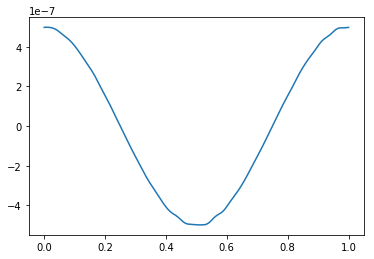

In [275]:
plt.plot(q3plot, bb)

In [308]:
pic_accumu.accumulation_step3(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat11, mat12, mat13, mat22, mat23, mat33, vec1, vec2, vec3)

In [314]:
BLOCK = np.block([[mat11.reshape(Ntot, Ntot), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [mat12.reshape(Ntot, Ntot).T, mat22.reshape(Ntot, Ntot), mat23.reshape(Ntot, Ntot)], [mat13.reshape(Ntot, Ntot).T, mat23.reshape(Ntot, Ntot).T, mat33.reshape(Ntot, Ntot)]])

In [338]:
def update():
    
    # step 1 (update u)
    pic_accumu.accumulation_step1(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat12, mat13, mat23)
    
    AJ11A = np.block([[np.zeros((Ntot, Ntot)), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [-mat12.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot)), mat23.reshape(Ntot, Ntot)], [-mat13.reshape(Ntot, Ntot).T, -mat23.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot))]])
    
    u[:] = np.linalg.solve(A - dt/2*AJ11A, (A + dt/2*AJ11A).dot(u))
    
    
    # step 2 (update first u, then b and evaluate B-field at particle positions)
    u_old[:] = u
    
    u[:] = STEP2_schur_LU.solve(STEP2_1.dot(u_old) + STEP2_2.dot(b))
    b[:] = b - dt/2*CURL.dot(TAU.dot(u_old + u))
    
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    
    
    # step 3 (update first u, then evaluate U-field at particle positions and then update V)
    pic_accumu.accumulation_step3(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat11, mat12, mat13, mat22, mat23, mat33, vec1, vec2, vec3)
    
    BLOCK = np.block([[mat11.reshape(Ntot, Ntot), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [mat12.reshape(Ntot, Ntot).T, mat22.reshape(Ntot, Ntot), mat23.reshape(Ntot, Ntot)], [mat13.reshape(Ntot, Ntot).T, mat23.reshape(Ntot, Ntot).T, mat33.reshape(Ntot, Ntot)]])
    
    u_old[:] = u
    
    u[:] = np.linalg.solve(A + dt**2/4*BLOCK, (A - dt**2/4*BLOCK).dot(u_old) + dt*np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten())))
    
    pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(1/2*(u + u_old)[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
    
    pic_pusher.pusher_step3(particles, L, dt, B_part, U_part)
    
    # step 4 (update Q and spans)
    pic_pusher.pusher_step4(particles, L, dt)
    
    spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
    spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
    spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]
    
    # step 5 (update V)
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    pic_pusher.pusher_step5(particles, L, dt, B_part)

In [277]:
# alternative solution for step2
LHS = sparse.bmat([[A, -dt/2*TAU.T.dot(CURL.T.dot(M2))], [dt/2*CURL.dot(TAU), sparse.identity(3*Ntot)]], format='csc')
RHS = sparse.bmat([[A, dt/2*TAU.T.dot(CURL.T.dot(M2))], [-dt/2*CURL.dot(TAU), sparse.identity(3*Ntot)]], format='csc')

LHS_LU = sparse.linalg.splu(LHS)

def update():
    
    S = LHS_LU.solve(RHS.dot(np.concatenate((u, b))))
    
    u[:] = S[:3*Ntot]
    b[:] = S[3*Ntot:]

In [339]:
Nt = 8000

for n in range(Nt):
    
    print('steps done', n)
    
    update()
    
    # compute energies
    en_U = 1/2*u.dot(A.dot(u))
    en_B = 1/2*b.dot(M2.dot(b))
    en_H = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)
    
    energies = np.vstack((energies, np.array([en_U, en_B, en_H])))
    print(energies[n + 1], en_U + en_B + en_H)

steps done 0
[2.27143287e-08 1.56686860e-10 8.63887121e-01] 0.8638871442465246
steps done 1
[6.19959668e-08 2.51613679e-09 8.63887080e-01] 0.8638871442465246
steps done 2
[1.07121413e-07 1.35799851e-08 8.63887024e-01] 0.8638871442465245
steps done 3
[1.68588819e-07 3.42928224e-08 8.63886941e-01] 0.8638871442465246
steps done 4
[2.46115548e-07 5.88188335e-08 8.63886839e-01] 0.8638871442465248
steps done 5
[3.45313969e-07 9.14827013e-08 8.63886707e-01] 0.8638871442465247
steps done 6
[4.62119019e-07 1.21487267e-07 8.63886561e-01] 0.8638871442465247
steps done 7
[5.70896158e-07 1.53934070e-07 8.63886419e-01] 0.8638871442465249
steps done 8
[6.74731209e-07 1.81642648e-07 8.63886288e-01] 0.8638871442465248
steps done 9
[8.33020778e-07 2.04228911e-07 8.63886107e-01] 0.8638871442465248
steps done 10
[9.98105783e-07 2.42692002e-07 8.63885903e-01] 0.8638871442465249
steps done 11
[1.14321135e-06 2.92441705e-07 8.63885709e-01] 0.863887144246525
steps done 12
[1.31364617e-06 3.42934041e-07 8.6388

KeyboardInterrupt: 

In [340]:
en_U = energies[:, 0]
en_B = energies[:, 1]
en_H = energies[:, 2]

en_tot = en_U + en_B + en_H


Nt = len(en_U) - 1

tn = np.linspace(0., Nt*dt, Nt + 1)

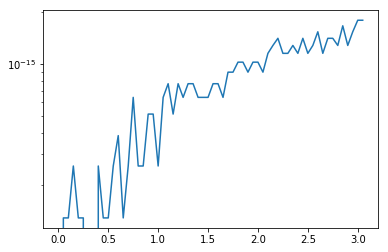

In [341]:
plt.semilogy(tn, np.abs(en_tot - en_tot[0])/en_tot[0])
#plt.xlim((0., 20.))

In [342]:
en_tot

array([0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714, 0.86388714, 0.86388714, 0.86388714,
       0.86388714, 0.86388714])

(1e-07, 0.001)

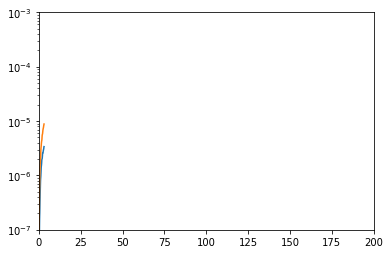

In [344]:
plt.semilogy(tn, en_B)
plt.semilogy(tn, en_U)
plt.xlim((0., 200.))
plt.ylim((1e-7, 1e-3))
#plt.semilogy(tn, 1e-5*np.exp(2*0.04*tn), 'k--')